In [1609]:
import os
import pandas as pd
import pickle
import imblearn
import numpy as np
import sklearn
import copy
from pandasql import *
from pandasql import sqldf
sql = lambda q: sqldf(q, globals()) 

from sklearn.decomposition import PCA
from scipy import interp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, f1_score

import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix,f1_score
from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score, make_scorer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

pd.set_option('display.float_format', lambda x: '%.3f' %x)
pd.set_option('display.float_format', lambda x: '%.f' %x)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)  
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,8

print('This file is located in the following directory: \n'+os.getcwd())

This file is located in the following directory: 
/Users/Work/Desktop/Work/Projects/Machine Learning Engineer Nanodegree/mortgage data


## Import performance and acquisitions datasets

In [831]:
file=open('/Users/Work/Downloads/Fannie Mae Loan Files/2016Q1/Performance_2016Q1.txt','r')
lines = file.read().split("\n")
temp=[]
for j in lines:
    temp.append(j.split('|'))
perf_2016Q1=pd.DataFrame(temp)

file=open('/Users/Work/Downloads/Fannie Mae Loan Files/2016Q1/Acquisition_2016Q1.txt','r')
lines = file.read().split("\n")
temp=[]
for j in lines:
    temp.append(j.split('|'))
acq_2016Q1=pd.DataFrame(temp)

loc='/Users/Work/Desktop/Work/Projects/Machine Learning Engineer Nanodegree/mortgage data/'

Performance_Variables = ("LOAN_ID", "Monthly.Rpt.Prd", "Servicer.Name", "LAST_RT", "LAST_UPB", "Loan.Age", "Months.To.Legal.Mat"
, "Adj.Month.To.Mat", "Maturity.Date", "MSA", "Delq.Status", "MOD_FLAG", "Zero.Bal.Code",
"ZB_DTE", "LPI_DTE", "FCC_DTE","DISP_DT", "FCC_COST", "PP_COST", "AR_COST", "IE_COST", "TAX_COST", "NS_PROCS",
"CE_PROCS", "RMW_PROCS", "O_PROCS", "NON_INT_UPB", "PRIN_FORG_UPB_FHFA", "REPCH_FLAG", "PRIN_FORG_UPB_OTH", "TRANSFER_FLAG")
perf_2016Q1.columns=Performance_Variables

Acquisition_Variables=("LOAN_ID", "ORIG_CHN", "Seller.Name", "ORIG_RT", "ORIG_AMT", "ORIG_TRM", "ORIG_DTE"
                           ,"FRST_DTE", "OLTV", "OCLTV", "NUM_BO", "DTI", "CSCORE_B", "FTHB_FLG", "PURPOSE", "PROP_TYP"
                           ,"NUM_UNIT", "OCC_STAT", "STATE", "ZIP_3", "MI_PCT", "Product.Type", "CSCORE_C", "MI_TYPE", "RELOCATION_FLG")
acq_2016Q1.columns=Acquisition_Variables

## Create outcome variable "did loan miss at least 3 consecutive payments at some point?" Yes/no.

In [832]:
defaults=perf_2016Q1[perf_2016Q1['Delq.Status'].isin(['3', '4', '5', '6', '7', '8', '9', '10', '11', '12'] )]
defaults=defaults['LOAN_ID'].unique()
acq_2016Q1['default']=acq_2016Q1['LOAN_ID'].isin(defaults)

In [854]:
acq_2016Q1.groupby('default').size()

default
False    302754
True        649
dtype: int64

In [855]:
len(acq_2016Q1[acq_2016Q1.default==True])==len(defaults)
#check: does the acq_2016Q1 dataset have all defaulted loans?

True

## Drop superfluous row in acq_2016Q1 table

In [833]:
acq_2016Q1=acq_2016Q1.drop(303402,axis=0) #I don't know how this row got here

## Create seasonality field

In [834]:
temp=[]
for x in acq_2016Q1['ORIG_DTE']:
    temp.append(str(x)[:2])

def season(x):
    if x in[1,2,12]:
        return "Winter" 
    elif x in [3,4,5]:
        return "Spring" 
    elif x in [6,7,8]:
        return "Summer"
    elif x in [9,10,11]:
        return "Autumn"    
    
temp=pd.Series(temp)
temp=pd.to_numeric(temp)
temp=temp.map(season)
acq_2016Q1['ORIG_SE']=temp
acq_2016Q1=acq_2016Q1.drop('ORIG_DTE',axis=1)

## Load acq_2016Q here (prior to dropping state, adding region)

In [835]:
pickle.dump(acq_2016Q1, open('mortgage_data_acq_2016Q1.sav', 'wb'))

In [1603]:
acq_2016Q1 = pickle.load(open('mortgage_data_acq_2016Q1.sav', 'rb'))

# Create region field

In [916]:
state_mapping = pd.read_csv("/Users/Work/Desktop/Work/Projects/Datasets/state_mapping_data.csv")
state_mapping_dict = dict(zip(state_mapping['State Code'], state_mapping['Region']))
data_states=pd.Series(acq_2016Q1['STATE'].unique())
dict_states=pd.Series(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 
                       'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY',
                       'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT',
                       'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 
                       'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 
                       'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])
not_in_dict=data_states.isin(dict_states)==False
data_states[not_in_dict]
state_mapping_dict['PR']='South'
state_mapping_dict['VI']='South'
state_mapping_dict['GU']='South'
acq_2016Q1['REGION']=acq_2016Q1['STATE'].map(state_mapping_dict)
acq_2016Q1=acq_2016Q1.drop(['STATE'],axis=1)

49    PR
52    VI
53    GU
dtype: object

## Make final dataframe

In [917]:
df=acq_2016Q1[['ORIG_CHN','ORIG_RT','ORIG_AMT', 'ORIG_TRM','ORIG_SE', 'OLTV', 'PURPOSE', 
    'NUM_BO', 'DTI','CSCORE_B','FTHB_FLG', 'PROP_TYP', 'NUM_UNIT', 'OCC_STAT', 
    'MI_PCT', 'CSCORE_C','MI_TYPE', 'RELOCATION_FLG','REGION','default']]

### Remove 3 predictors with too many missing values

In [918]:
#missing values check
df=df.replace('',np.NaN)
df_null_count=df.isnull().sum(axis=0)
df_null_count 
# % of each predictor's values that are missing

ORIG_CHN               0
ORIG_RT                0
ORIG_AMT               0
ORIG_TRM               0
ORIG_SE                0
OLTV                   0
PURPOSE                0
NUM_BO                 0
DTI                   72
CSCORE_B             114
FTHB_FLG               0
PROP_TYP               0
NUM_UNIT               0
OCC_STAT               0
MI_PCT            204329
CSCORE_C          160762
MI_TYPE           204329
RELOCATION_FLG         0
REGION                 0
default                0
dtype: int64

In [919]:
df=df.drop(['MI_PCT','CSCORE_C','MI_TYPE'],axis=1)
pickle.dump(df, open('mortgage_data.sav', 'wb'))

## DON'T LOAD THIS ONE:
Load dataframe (pre-feature scaling, one-hot-encoding, etc),        Wrangling done thus far: season variable, removed predictors with too many missing values

In [907]:
df = pickle.load(open('mortgage_data.sav', 'rb')) #includes ORIG_TRM

## Working off just a subset of the data

In [922]:
#make df of just observations with missing values
#make df with observations with missing values removed
#do this to append all missing observations to df_downsampled so i can work with missing data!
missing_indices=df[df.CSCORE_B.isnull() | df.DTI.isnull()].index.values
obs_with_missing=df.iloc[missing_indices,]
df_missing_removed=df.drop(missing_indices,axis=0)

from sklearn.utils import resample
df_majority = df_missing_removed[df_missing_removed.default==0]
df_minority = df_missing_removed[df_missing_removed.default==1]
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=4165,     # to match minority class
                                 random_state=123) # reproducible results
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled=pd.concat([df_downsampled,obs_with_missing],axis=0)
df_downsampled.default.value_counts()

pickle.dump(df_downsampled, open('mortgage_data_downsampled.sav', 'wb'))

False    4351
True      649
Name: default, dtype: int64

In [923]:
df_downsampled = pickle.load(open('mortgage_data_downsampled.sav', 'rb')) #includes ORIG_TRM
#this is the same as the loaded dataframe below

# LOAD THIS ONE! 
Downsampled dataframe with only 5000 observations and all 649 defaults (loans defaulting for 3 consecutive months or more)

In [1587]:
df = pickle.load(open('mortgage_data_downsampled.sav', 'rb')).reset_index().drop('index',axis=1)

df.shape
df.dtypes #need to convert numeric columns to numeric data type to produce correlations
df[['ORIG_RT','ORIG_AMT','ORIG_TRM','OLTV','DTI',\
    'NUM_BO','CSCORE_B','NUM_UNIT']] =\
    df[['ORIG_RT','ORIG_AMT','ORIG_TRM','OLTV','DTI',\
    'NUM_BO','CSCORE_B','NUM_UNIT']].apply(pd.to_numeric)
df.dtypes #numeric predictors are now converted!

(5000, 17)

ORIG_CHN          object
ORIG_RT           object
ORIG_AMT          object
ORIG_TRM          object
ORIG_SE           object
OLTV              object
PURPOSE           object
NUM_BO            object
DTI               object
CSCORE_B          object
FTHB_FLG          object
PROP_TYP          object
NUM_UNIT          object
OCC_STAT          object
RELOCATION_FLG    object
REGION            object
default             bool
dtype: object

ORIG_CHN           object
ORIG_RT           float64
ORIG_AMT            int64
ORIG_TRM            int64
ORIG_SE            object
OLTV                int64
PURPOSE            object
NUM_BO              int64
DTI               float64
CSCORE_B          float64
FTHB_FLG           object
PROP_TYP           object
NUM_UNIT            int64
OCC_STAT           object
RELOCATION_FLG     object
REGION             object
default              bool
dtype: object

## Exploratory Data Analysis

### Numeric Predictor Correlations

Multicollinearity, where predictors are highly correlated, can distort model results, such as variable importances.  Numeric predictors appear to all have weak correlations (<.3), so this does not appear to be a problem.

In [1588]:
df.corr()

,ORIG_RT,ORIG_AMT,ORIG_TRM,OLTV,NUM_BO,DTI,CSCORE_B,NUM_UNIT,default
ORIG_RT,1.000,-0.143,-0.008,0.104,-0.107,0.156,-0.423,0.143,0.222
ORIG_AMT,-0.143,1.000,-0.013,0.015,0.156,0.074,0.056,0.137,-0.041
ORIG_TRM,-0.008,-0.013,1.000,0.000,-0.009,0.025,-0.016,0.007,0.009
OLTV,0.104,0.015,0.000,1.000,-0.025,0.072,-0.091,-0.101,0.100
NUM_BO,-0.107,0.156,-0.009,-0.025,1.000,-0.093,0.146,-0.036,-0.134
DTI,0.156,0.074,0.025,0.072,-0.093,1.000,-0.195,0.002,0.130
CSCORE_B,-0.423,0.056,-0.016,-0.091,0.146,-0.195,1.000,0.022,-0.355
NUM_UNIT,0.143,0.137,0.007,-0.101,-0.036,0.002,0.022,1.000,-0.033
default,0.222,-0.041,0.009,0.100,-0.134,0.130,-0.355,-0.033,1.000


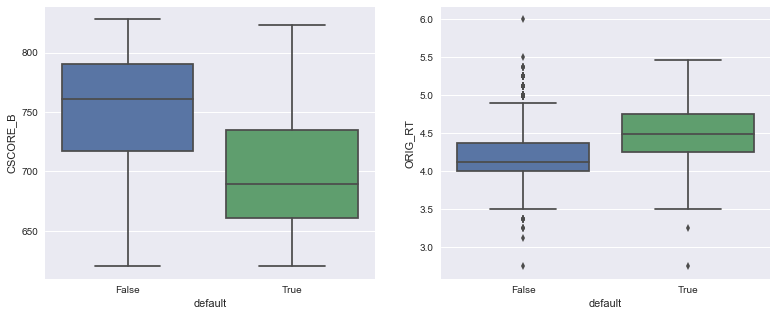

In [1589]:
#df_original.boxplot(column='CSCORE_B',by='default')
df_original=copy.deepcopy(df)
fig, axes = plt.subplots(1,2,figsize=(13,5))
sns.boxplot(x="default", y="CSCORE_B", data=df_original,ax=axes[0])
sns.boxplot(x="default", y="ORIG_RT", data=df_original,ax=axes[1])

In [1590]:
for j in range(0,8):
    print(df.mean().index.values[j],"   ", round(((df.groupby('default').mean().iloc[1,j]
         -df.groupby('default').mean().iloc[0,j])/df.mean().iloc[j])*100,3),"%")

ORIG_RT     5.452 %
ORIG_AMT     -6.172 %
ORIG_TRM     0.01 %
OLTV     5.852 %
NUM_BO     -14.176 %
DTI     9.603 %
CSCORE_B     -7.042 %
NUM_UNIT     -2.653 %


In [1591]:
df.groupby('default').mean()

,ORIG_RT,ORIG_AMT,ORIG_TRM,OLTV,NUM_BO,DTI,CSCORE_B,NUM_UNIT
default,,,,,,,,
False,4.210,239472.305,359.928,76.906,1.471,34.172,751.262,1.043
True,4.441,224808.937,359.963,81.441,1.267,37.496,698.847,1.015


For each predictor, I inspect above whether there is a sizable difference between its mean value for each value of the outcome variable, meaning for loans that eventually default for 3 consecutive months or more and loans that do not.  

Most predictors appear to have values that are fairly close, regardless of the outcome's level.  Origination rate (ORIG_RT), Origination Loan-to-Value (OLTV), and Borrower Credit Score (CSCORE_B), might have sizable enough differences to offer value as predictors.  The average credit score for defaulters, 699, is typically regarded as indicating "good credit", while the average credit score for non-defaulters, is typically regarded as indicating "excellent credit" (source: https://www.nerdwallet.com/blog/finance/credit-score-ranges-and-how-to-improve/). This apparent difference in the credit score quality between defaulters and non-defaulters is indicative of a predictive relationship between credit score and defaulting.  

### Categorical Predictor Correlations

For each categorical predictor, I inspect whether there is a sizable difference between each level’s proportion of observations that defaulted.  If a certain level has many defaults compared with other levels, then when the predictor has as a value that level, then it is more likely that the outcome will have value 'default'.

ORIG_SE and RELOCATION_FLG, appear to offer the biggest differences between the proportion of defaults among their levels.  For predictor ORIG_SE, loans originated during the Autumn saw 16.5% of their loans as eventually defaulting, compared to loans that originated in Spring, which only saw 8% of their loans defaulting.  Each of these levels had a sizable number of originated loans, thus giving greater credibility to these default percentages.  For predictor RELOCATION_FLG, which represents mortgages that companies make available to relocating employees, only 1.3% of these mortgages default, compared with all other mortgages (non-relocation mortgages), which default at a rate of 13%.  

In [1592]:
df_orig_categoricals=df_original.drop(['ORIG_RT','ORIG_AMT','ORIG_TRM','OLTV','DTI','NUM_BO','CSCORE_B','NUM_UNIT'],axis=1)

for j in range(0,8):
    ct=pd.crosstab(index=df_orig_categoricals.default,columns=df_orig_categoricals.iloc[:,j])
    ct
    for j in range(len(ct.columns)):
        print(ct.iloc[:,j].name, round(ct.iloc[1,j]/np.sum(ct.iloc[:,j]),4))

ORIG_CHN,B,C,R
default,,,
False,445,1305,2601
True,62,232,355


B 0.1223
C 0.1509
R 0.1201


ORIG_SE,Autumn,Spring,Summer,Winter
default,,,,
False,496,372,13,3470
True,98,36,6,509


Autumn 0.165
Spring 0.0882
Summer 0.3158
Winter 0.1279


PURPOSE,C,P,R
default,,,
False,835,2615,901
True,140,395,114


C 0.1436
P 0.1312
R 0.1123


FTHB_FLG,N,Y
default,,
False,3316,1035
True,463,186


N 0.1225
Y 0.1523


PROP_TYP,CO,CP,MH,PU,SF
default,,,,,
False,444,14,27,1244,2622
True,48,0,7,166,428


CO 0.0976
CP 0.0
MH 0.2059
PU 0.1177
SF 0.1403


OCC_STAT,I,P,S
default,,,
False,402,3773,176
True,34,597,18


I 0.078
P 0.1366
S 0.0928


RELOCATION_FLG,N,Y
default,,
False,4275,76
True,648,1


N 0.1316
Y 0.013


REGION,Midwest,Northeast,South,West
default,,,,
False,766,585,1391,1609
True,136,76,236,201


Midwest 0.1508
Northeast 0.115
South 0.1451
West 0.111


In [1593]:
df.describe().loc[['min','max'],:]
df.describe()

,ORIG_RT,ORIG_AMT,ORIG_TRM,OLTV,NUM_BO,DTI,CSCORE_B,NUM_UNIT
min,2.750,20000.000,312.000,11.000,1.000,3.000,620.000,1.000
max,6.000,903000.000,360.000,97.000,4.000,50.000,828.000,4.000


,ORIG_RT,ORIG_AMT,ORIG_TRM,OLTV,NUM_BO,DTI,CSCORE_B,NUM_UNIT
count,5000.000,5000.000,5000.000,5000.000,5000.000,4928.000,4886.000,5000.000
mean,4.240,237569.000,359.933,77.494,1.445,34.610,744.300,1.039
std,0.349,120280.316,1.360,15.174,0.514,8.671,50.058,0.277
min,2.750,20000.000,312.000,11.000,1.000,3.000,620.000,1.000
25%,4.000,144000.000,360.000,70.000,1.000,29.000,705.000,1.000
50%,4.250,216500.000,360.000,80.000,1.000,36.000,754.000,1.000
75%,4.500,315000.000,360.000,90.000,2.000,42.000,787.000,1.000
max,6.000,903000.000,360.000,97.000,4.000,50.000,828.000,4.000


## SANITY CHECK: Do the predictor max/min values look reasonable?

The <i> Fannie Mae Single-Family Loan Performance Data Glossary </i> provides variable information, including ranges.  I look at the data's actual ranges to make sure values are not outside the ranges shown on the glossary.

1. ORIG_RT appears to have reasonable min/max values (2.75,6)

2. ORIG_AMT does not appear to have any unreasonable min/max values.  For instance, the benchmark
paper found zero values for ORIG_AMT, which makes no sense, and so these records were removed.

3. ORIG_TRM looks okay.

4. OLTV looks okay.  Fannie Mae has stated in the 
 loans whose LTVs are above 97%
are excluded so that all data is consistent with current underwriting guidelines.  

5. NUM_BO can take a value between 1-10, according to the glossary, and min/max values here are[1,6], which is therefore reasonable.

6. DTI can be 1-64% according to the glossary, so this looks okay.

7. CSCORE_B looks okay, since values can range from 300-850, and are blank if they fall outside this range.

8. NUM_UNIT can range from 1-4, so the data looks okay.

# Missing Values Check

In [1594]:
df.isnull().sum()

ORIG_CHN            0
ORIG_RT             0
ORIG_AMT            0
ORIG_TRM            0
ORIG_SE             0
OLTV                0
PURPOSE             0
NUM_BO              0
DTI                72
CSCORE_B          114
FTHB_FLG            0
PROP_TYP            0
NUM_UNIT            0
OCC_STAT            0
RELOCATION_FLG      0
REGION              0
default             0
dtype: int64

# Checking Numerical Predictor Distributions for Normality

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1772a9a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x177732b38>]], dtype=object)

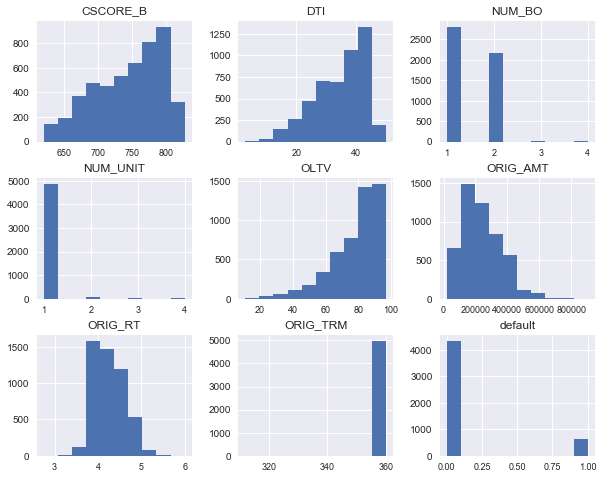

In [1595]:
df_original.hist(xlabelsize=9)

CSCORE_B, DTI, OLTV and ORIG_AMT have skewed distributions, so log transforms will be applied.

# Log transform skewed numeric predictors

In [1596]:
df[['CSCORE_B', 'DTI', "OLTV", "ORIG_AMT"]]=df[['CSCORE_B', 'DTI', "OLTV", "ORIG_AMT"]].apply(np.log)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x17773c630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1771390b8>]], dtype=object)

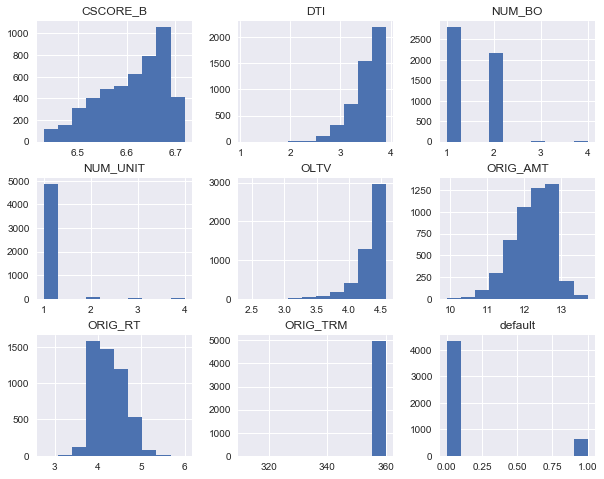

In [1597]:
df.hist()

# Remove ORIG_TRM, which has low variance and low correlation

In [1598]:
df=df.drop('ORIG_TRM',axis=1)

# Converting the categorical predictors

In [1599]:
dummies=pd.get_dummies(df[['ORIG_CHN','ORIG_SE','PURPOSE',
                'FTHB_FLG','PROP_TYP','OCC_STAT','RELOCATION_FLG','REGION']],drop_first=True)
df=pd.concat([df,dummies],axis=1)
df=df.drop(['ORIG_CHN','ORIG_SE','PURPOSE','FTHB_FLG','PROP_TYP','OCC_STAT','RELOCATION_FLG','REGION'],axis=1)
pickle.dump(df, open('final_dataframe.sav', 'wb'))

# LOAD THIS ONE! 
Downsampled dataframe with only 5000 observations and all 649 defaults (loans defaulting for 3 consecutive months or more)

In [1600]:
df = pickle.load(open('final_dataframe.sav', 'rb'))

# Parameters for 3-Fold Nested Cross Validation (3-Fold CV)

In [1583]:
X=df.drop('default',axis=1)
y=df['default']
smote = SMOTE(random_state=0,ratio='minority') #to upsample to get 20% minority
median_imputer=Imputer(missing_values='NaN', strategy='median', axis=0)
scaler=MinMaxScaler()
base=DecisionTreeClassifier(max_depth=1, random_state=0) 
feature_selection=SelectFromModel(RandomForestClassifier(n_estimators=50, random_state=0))

classifiers = [
    DecisionTreeClassifier(random_state=0),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                      metric='minkowski', metric_params=None, n_jobs=1),
    RandomForestClassifier(warm_start=True, oob_score=True,random_state=0,n_estimators=300),
    svm.SVC(random_state=0,probability=True), 
    AdaBoostClassifier(base_estimator=base, n_estimators = 100, random_state=0) ,
    GradientBoostingClassifier(random_state=0, max_features='sqrt'),
    GaussianNB()]

param=list()
cross_val=list()
method_names=['Decision Tree','Logistic Regression', 'K Nearest Neighbors', 'Random Forests',
             'Support Vector Machines', 'AdaBoost', 'Gradient Boosting Classifier','Naive Bayes']

param.append({"fselect__threshold":[1e-5,1e-4,1e-3], "clf__max_depth":[2,3,4,5]})
param.append({"fselect__threshold":[1e-5,1e-4,1e-3],'clf__C': [10**-4, 10**-2, 10**0, 10**2, 10**4]})
param.append({"fselect__threshold":[1e-5,1e-4,1e-3],'clf__n_neighbors': [3,4,5,6,7]})
param.append({"fselect__threshold":[1e-5,1e-4,1e-3],'clf__max_features': ['sqrt',.2,.5,.8]})
param.append({"fselect__threshold":[1e-5,1e-4,1e-3],'clf__C': [.001, .01, .1, 1, 10], "clf__gamma": [.001, .01, .1, 1]})
param.append({"fselect__threshold":[1e-5,1e-4,1e-3],'clf__learning_rate': [.01,.1,1,2]})
param.append({"fselect__threshold":[1e-5,1e-4,1e-3],"clf__learning_rate": [.001,.01,.1], "clf__max_depth":[3,4,5]})
param.append({"fselect__threshold":[1e-5,1e-4,1e-3]})

inner_fold = StratifiedKFold(random_state=0)
outer_fold = StratifiedKFold(random_state=0)

mean_fpr = np.linspace(0, 1, 100)
colors=['b','g','r','y','k','c','m','orange']

# 3-Fold Cross Validation - No Hyperparameter Tuning

In [1608]:
cross_val_metrics=list()
metrics_f1_score=list()

scoring = make_scorer(f1_score)
scoring2 = {'AUC': make_scorer(roc_auc_score),'Accuracy': make_scorer(accuracy_score),'Precision': make_scorer(precision_score), 
           'Recall': make_scorer(recall_score),'F1 Score': make_scorer(f1_score)}

for k in range(len(classifiers)):
    pipeline = Pipeline([('median_imputer',median_imputer),('scaler', scaler),
                       ('fselect',feature_selection),
                       ('clf', classifiers[k])])
    cross_val_metrics.append((method_names[k],cross_validate(pipeline, X, y, cv=outer_fold, scoring = scoring2,
                                                            return_train_score=False)))

for j in range(len(cross_val_metrics)):
    metrics1=list()
    metrics1.append(method_names[j])
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_AUC']))
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_Accuracy']))
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_F1 Score']))
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_Precision']))
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_Recall']))
    metrics_f1_score.append(metrics1)  
    
labels = ['Method','AUC','Accuracy','F1 Score','Precision','Recall']
classifier_metrics_original=pd.DataFrame.from_records(metrics_f1_score,columns=labels)
classifier_metrics_original.sort_values('F1 Score',ascending=False)

/Users/Work/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Work/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Work/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Work/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Work/

,Method,AUC,Accuracy,F1 Score,Precision,Recall
7,Naive Bayes,0.651,0.857,0.403,0.441,0.373
2,K Nearest Neighbors,0.595,0.862,0.306,0.441,0.236
0,Decision Tree,0.600,0.810,0.302,0.289,0.316
5,AdaBoost,0.584,0.872,0.283,0.522,0.196
3,Random Forests,0.584,0.868,0.281,0.489,0.200
6,Gradient Boosting Classifier,0.575,0.869,0.260,0.504,0.177
1,Logistic Regression,0.546,0.871,0.175,0.536,0.106
4,Support Vector Machines,0.500,0.870,0.000,0.000,0.000


# Nested 3-Fold Cross Validation - Optimizing for F1 Score - All Metrics

In [1584]:
cross_val_metrics=list()
metrics_f1_score=list()

scoring = make_scorer(f1_score)
scoring2 = {'AUC': make_scorer(roc_auc_score),'Accuracy': make_scorer(accuracy_score),'Precision': make_scorer(precision_score), 
           'Recall': make_scorer(recall_score),'F1 Score': make_scorer(f1_score)}

for k in range(len(classifiers)):
    pipeline = Pipeline([('median_imputer',median_imputer),('scaler', scaler),
                       ('fselect',feature_selection), ('smote', smote), 
                       ('clf', classifiers[k])])
    
    no_param=list()
    for classifier in param[k].values(): #set 1 = k (for each param grid)
        for param_values in classifier:  #for each param in param grid
            no_param.append(param_values) #append that param's values 
    no_param=len(no_param)
    
    random_search = RandomizedSearchCV(pipeline, n_iter=no_param, param_distributions=param[k],cv = inner_fold,
                                                                scoring=scoring,random_state=0)
    cross_val_metrics.append((method_names[k],cross_validate(random_search, X, y, cv=outer_fold, scoring = scoring2,
                                                            return_train_score=False)))


for j in range(len(cross_val_metrics)):
    metrics1=list()
    metrics1.append(method_names[j])
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_AUC']))
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_Accuracy']))
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_F1 Score']))
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_Precision']))
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_Recall']))
    metrics_f1_score.append(metrics1)  
    
labels = ['Method','AUC','Accuracy','F1 Score','Precision','Recall']
classifier_metrics_f1_score=pd.DataFrame.from_records(metrics_f1_score,columns=labels)
classifier_metrics_f1_score.sort_values('F1 Score',ascending=False)

,Method,AUC,Accuracy,F1 Score,Precision,Recall
6,Gradient Boosting Classifier,0.730,0.777,0.437,0.326,0.667
5,AdaBoost,0.706,0.796,0.426,0.337,0.584
4,Support Vector Machines,0.730,0.740,0.417,0.294,0.718
1,Logistic Regression,0.727,0.743,0.416,0.295,0.706
0,Decision Tree,0.720,0.741,0.412,0.296,0.692
3,Random Forests,0.646,0.840,0.384,0.386,0.384
2,K Nearest Neighbors,0.610,0.711,0.297,0.218,0.474
7,Naive Bayes,0.623,0.477,0.294,0.180,0.821


# Nested 3-Fold Cross Validation - Optimizing for AUC - All Metrics

In [947]:
cross_val_metrics=list()
metrics=list()

scoring = make_scorer(roc_auc_score)
scoring2 = {'AUC': make_scorer(roc_auc_score),'Accuracy': make_scorer(accuracy_score),'Precision': make_scorer(precision_score), 
           'Recall': make_scorer(recall_score),'F1 Score': make_scorer(f1_score)}

for k in range(len(classifiers)):
    pipeline = Pipeline([('median_imputer',median_imputer),('scaler', scaler),
                       ('fselect',feature_selection), ('smote', smote), 
                       ('clf', classifiers[k])])
    
    no_param=list()
    for classifier in param[k].values(): #set 1 = k (for each param grid)
        for param_values in classifier:  #for each param in param grid
            no_param.append(param_values) #append that param's values 
    no_param=len(no_param)
    

    random_search = RandomizedSearchCV(pipeline, n_iter=no_param, param_distributions=param[k],cv = inner_fold,
                                                                scoring=scoring,random_state=0)
    cross_val_metrics.append((method_names[k],cross_validate(random_search, X, y, cv=outer_fold, scoring = scoring2,
                                                            return_train_score=False)))


for j in range(len(cross_val_metrics)):
    metrics1=list()
    metrics1.append(method_names[j])
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_AUC']))
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_Accuracy']))
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_F1 Score']))
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_Precision']))
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_Recall']))
    metrics.append(metrics1)  
    
labels = ['Method','AUC','Accuracy','F1 Score','Precision','Recall']
classifier_metrics=pd.DataFrame.from_records(metrics,columns=labels)

In [1054]:
classifier_metrics.sort_values('F1 Score',ascending=False)

,Method,AUC,Accuracy,F1 Score,Precision,Recall
0,Decision Tree,0.718,0.739,0.409,0.293,0.690
1,Logistic Regression,0.727,0.743,0.416,0.296,0.704
2,K Nearest Neighbors,0.622,0.696,0.308,0.219,0.522
3,Random Forests,0.641,0.837,0.376,0.377,0.378
4,Support Vector Machines,0.730,0.740,0.417,0.294,0.718
5,AdaBoost,0.719,0.757,0.417,0.304,0.667
6,Gradient Boosting Classifier,0.729,0.761,0.428,0.311,0.686
7,Naive Bayes,0.623,0.477,0.294,0.180,0.821


# Confusion Matrices

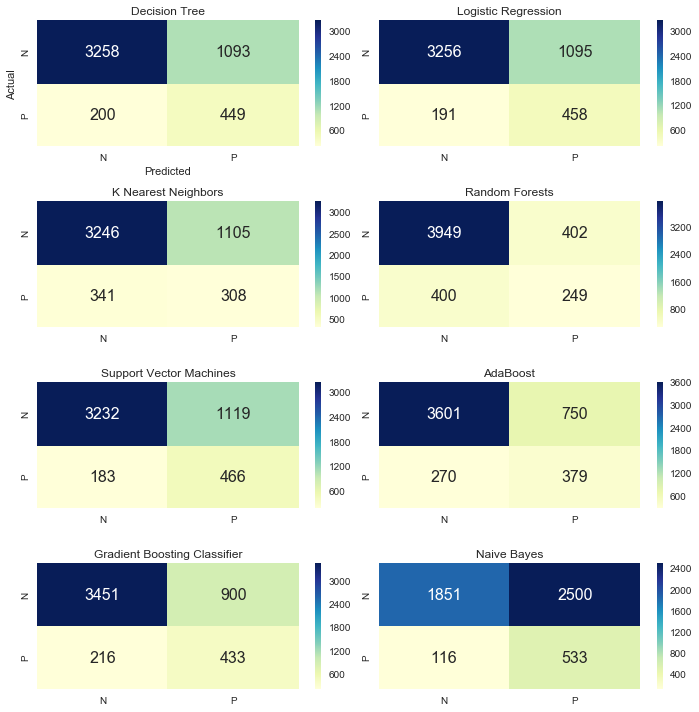

In [1065]:
fig, axes = plt.subplots(4,2,figsize=(10,10))
num_plots=len(classifiers)
scoring=make_scorer(f1_score)

for k in range(len(classifiers)):
    pipeline = Pipeline([('median_imputer',median_imputer),('scaler', scaler),
                ('fselect',feature_selection), ('smote', smote), ('clf', classifiers[k])])
    no_param=list()
    for classifier in param[k].values(): #set 1 = k (for each param grid)
        for param_values in classifier:  #for each param in param grid
            no_param.append(param_values) #append that param's values   
    random_search = RandomizedSearchCV(pipeline, n_iter=len(no_param), param_distributions=param[k],
                                       cv = inner_fold, scoring=scoring, random_state=0)
   
    i = 0  #in k-fold, each test split contains obs not in other splits, so each confusion matrix is for unique obs
           #add all confusion matrices together to get total test confusion matrix in kfold cross validation 
    
    for train, test in outer_fold.split(X, y):
        optimized_pipeline = random_search.fit(X.iloc[train,:],y[train])        
        y_pred=optimized_pipeline.predict(X.iloc[test,:])
        cnf_matrix = confusion_matrix(y[test], y_pred)
        if i==0:
            total_cnf_matrix = cnf_matrix
        else:
            total_cnf_matrix += cnf_matrix
        i=1
        
    df_cm = pd.DataFrame(total_cnf_matrix, ['N', 'P'], ['N', 'P'])
    
    if method_names[k]=='Decision Tree':
        df_cm.columns.name = 'Predicted'
        df_cm.index.name = 'Actual'
    
    #Plot each of the k subplots, where k is the number of classifiers
    row = k // 2  #specify subplot row location
    col = k % 2   #specify subplot column location 
    ax_curr = axes[row, col]
    sns.heatmap(df_cm, annot=True, annot_kws={'size':16}, fmt='g',cmap="YlGnBu",ax=ax_curr).set_title(method_names[k])
    plt.tight_layout()

# ROC Plots

(-0.05, 1.05)

(-0.05, 1.05)

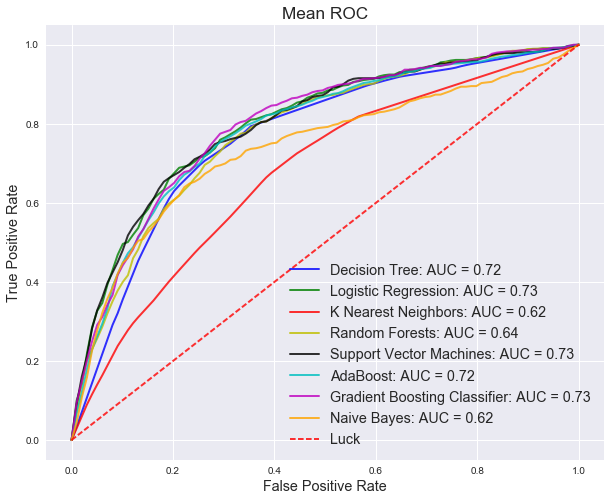

''

In [949]:
i = 0
scoring=make_scorer(roc_auc_score)

for k in range(len(classifiers)):
    no_param=list()
    pipeline = Pipeline([('median_imputer',median_imputer),('scaler', scaler),
                    ('fselect',feature_selection), ('smote', smote), ('clf', classifiers[k])])
    for classifier in param[k].values(): #set 1 = k (for each param grid)
        for param_values in classifier:  #for each param in param grid
            no_param.append(param_values) #append that param's values   
    random_search = RandomizedSearchCV(pipeline, n_iter=len(no_param), scoring=scoring,
                                       param_distributions=param[k],cv = inner_fold,random_state=0)
    #n_iter runs a number of times that is the # of params so that error is not generated 
    #any no of iterations greater than # of params generates error
    tprs = []
    aucs = []
    
    for train, test in outer_fold.split(X, y):
        optimized_pipeline = random_search.fit(X.iloc[train,:],y[train])
        probas_ = optimized_pipeline.predict_proba(X.iloc[test,:])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr) #calculated differently from roc_auc_score used in above methods
    mean_roc_auc_score = classifier_metrics['AUC'][k] #using 3-fold cross validation results to be consistent
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color=colors[k],
             label=r'%s: AUC = %0.2f' % (method_names[k],mean_roc_auc_score),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    #plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
    #                label=r'$\pm$ 1 std. dev.')
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize='x-large')
plt.ylabel('True Positive Rate',fontsize='x-large')
plt.title('Mean ROC',fontsize='xx-large')
plt.legend(loc="lower right",fontsize='x-large')
plt.show()
;

The models are labeling too many observations as defaults, since about only 30% of the default-labeled observations are actually defaults.  The models are labeling most defaulting observations as defaults, where the best models are correctly labeling 70% of defaults as defaults.  Accuracy is typically 70-80%, meaning the models are correctly predicting an where a loan defaults or not 70-80% of the time.  

The probability thresholds were not calibrated, however.

# The Benchmark Model - Logistic Regression

In [1693]:
X=df.drop('default',axis=1)
y=df['default']
smote = SMOTE(random_state=0,ratio='minority') #to upsample to get 20% minority
median_imputer=Imputer(missing_values='NaN', strategy='median', axis=0)
scaler=MinMaxScaler()
base=DecisionTreeClassifier(max_depth=1, random_state=0) 
feature_selection=SelectFromModel(RandomForestClassifier(n_estimators=50, random_state=0))

logit=LogisticRegression(random_state=0)

param=list()
cross_val=list()
method_names='Logistic Regression'
outer_fold = StratifiedKFold(random_state=0)

mean_fpr = np.linspace(0, 1, 100)
colors=['b','g','r','y','k','c','m','orange']

In [1700]:
cross_val_metrics=list()
metrics_logit=list()
scoring = make_scorer(f1_score)
scoring2 = {'AUC': make_scorer(roc_auc_score),'Accuracy': make_scorer(accuracy_score),'Precision': make_scorer(precision_score), 
           'Recall': make_scorer(recall_score),'F1 Score': make_scorer(f1_score)}


pipeline = Pipeline([('median_imputer',median_imputer),('scaler', scaler),
                       ('fselect',feature_selection), ('smote', smote), 
                       ('clf', logit)])

cross_val_metrics.append((method_names,cross_validate(pipeline, X, y, cv=outer_fold, scoring = scoring2,
                                                            return_train_score=False)))


for j in range(len(cross_val_metrics)):
    metrics1=list()
    metrics1.append(method_names)
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_AUC']))
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_Accuracy']))
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_F1 Score']))
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_Precision']))
    metrics1.append(np.mean(cross_val_metrics[j][1]['test_Recall']))
    metrics_logit.append(metrics1)  
    
labels = ['Method','AUC','Accuracy','F1 Score','Precision','Recall']
classifier_metrics_logit=pd.DataFrame.from_records(metrics_logit,columns=labels)
classifier_metrics_logit.sort_values('F1 Score',ascending=False)

,Method,AUC,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression,0.723,0.733,0.409,0.287,0.710


# ROC Plot for Gradient Boosting - By Cross Validation Fold

In [ ]:
scoring2 = {'AUC': make_scorer(roc_auc_score),'Accuracy': make_scorer(accuracy_score),'Precision': make_scorer(precision_score), 
           'Recall': make_scorer(recall_score),'F1 Score': make_scorer(f1_score)}

In [1685]:
for train, test in outer_fold.split(X, y):
    random_search = RandomizedSearchCV(pipeline, n_iter=9, param_distributions=param[0],cv = inner_fold,
                                       scoring=scoring,random_state=0)
    optimized_pipeline = random_search.fit(X.iloc[train,:],y[train])
    y_pred = optimized_pipeline.predict(X.iloc[test,:])
    
    gbc_accuracy.append(accuracy_score(y[test],y_pred))
    gbc_precision.append(precision_score(y[test],y_pred))
    gbc_recall.append(recall_score(y[test],y_pred))
    gbc_auc.append(roc_auc_score(y[test],y_pred))
    gbc_f1score.append(f1_score(y[test],y_pred))

,AUC,Accuracy,F1 Score,Precision,Recall
0,0.739,0.768,0.440,0.321,0.700
1,0.715,0.737,0.403,0.286,0.685
2,0.733,0.779,0.440,0.327,0.671


(-0.05, 1.05)

(-0.05, 1.05)

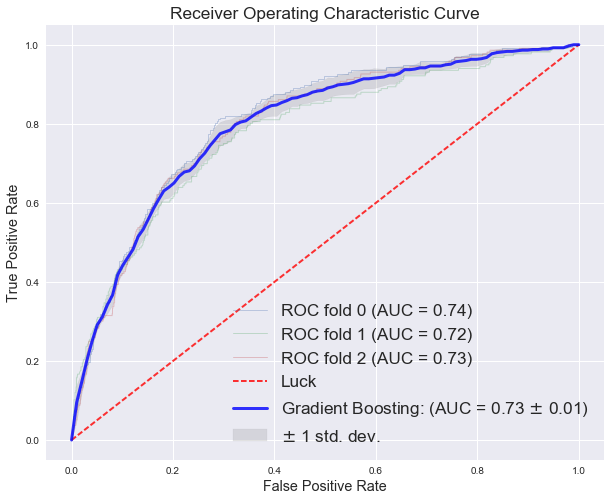

''

In [1689]:
tprs = []
aucs = []
aucs_alt = []
mean_fpr = np.linspace(0, 1, 100)
method='Gradient Boosting Classifier'
scoring = make_scorer(roc_auc_score)

gbc_accuracy=list()
gbc_precision=list()
gbc_recall=list()
gbc_auc=list()
gbc_f1score=list()

pipeline = Pipeline([('median_imputer',median_imputer),('scaler', scaler),
                    ('fselect',feature_selection), ('smote', smote), 
                    ('clf', GradientBoostingClassifier(random_state=0, max_features='sqrt'))])

param=list()
param.append({"fselect__threshold":[1e-5,1e-4,1e-3],"clf__learning_rate": [.001,.01,.1], "clf__max_depth":[3,4,5]})

i = 0
for train, test in outer_fold.split(X, y):
    random_search = RandomizedSearchCV(pipeline, n_iter=9, param_distributions=param[0],cv = inner_fold,
                                       scoring=scoring,random_state=0)
    optimized_pipeline = random_search.fit(X.iloc[train,:],y[train])
    y_pred = optimized_pipeline.predict(X.iloc[test,:])
    
    gbc_accuracy.append(accuracy_score(y[test],y_pred))
    gbc_precision.append(precision_score(y[test],y_pred))
    gbc_recall.append(recall_score(y[test],y_pred))
    gbc_auc.append(roc_auc_score(y[test],y_pred))
    gbc_f1score.append(f1_score(y[test],y_pred))
    
    probas_ = optimized_pipeline.predict_proba(X.iloc[test,:])
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    auc_alt = roc_auc_score(y[test],y_pred)
    aucs_alt.append(auc_alt)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, auc_alt))
    i += 1

gbc_metrics=pd.DataFrame({'Accuracy':gbc_accuracy,'Precision':gbc_precision,
              'Recall':gbc_recall,'AUC':gbc_auc,'F1 Score':gbc_f1score})    
gbc_metrics

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc_alt = np.mean(aucs_alt)
std_auc = np.std(aucs)
std_auc_alt = np.std(aucs_alt)
plt.plot(mean_fpr, mean_tpr, color='b',
label=r'%s: (AUC = %0.2f $\pm$ %0.2f)' % ('Gradient Boosting',mean_auc_alt, std_auc_alt),lw=3, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize='x-large')
plt.ylabel('True Positive Rate',fontsize='x-large')
plt.title('Receiver Operating Characteristic Curve',fontsize='xx-large')
plt.legend(loc="lower right",fontsize='xx-large')
plt.show()
;

# Variable Importances

In [1429]:
smote = SMOTE(random_state=0,ratio='minority') #to upsample to get 20% minority
median_imputer=Imputer(missing_values='NaN', strategy='median', axis=0)
scaler=MinMaxScaler()
base=DecisionTreeClassifier(max_depth=1, random_state=0) 
feature_selection=SelectFromModel(RandomForestClassifier(n_estimators=50, random_state=0))

X2=pd.DataFrame(median_imputer.fit_transform(X),columns=X.columns)
X2=pd.DataFrame(scaler.fit_transform(X2),columns=X.columns)
X2,y2=pd.DataFrame(smote.fit_sample(X2,y)[0]),smote.fit_sample(X2,y)[1]

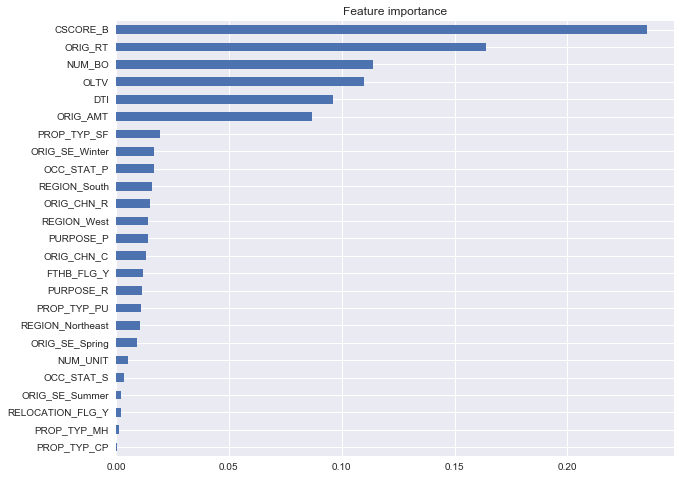

In [1196]:
folds = StratifiedKFold(random_state=0,n_splits=5)
rf=RandomForestClassifier(warm_start=True, oob_score=True,random_state=0,n_estimators=300)
pipeline_rf = Pipeline([('median_imputer',median_imputer),('scaler', scaler),
                        ('smote', smote), ('clf', rf)])
feat_imp=list()

fitted_rf=pipeline_rf.fit(X,y)
feat_imp=pd.Series(fitted_rf.named_steps.clf.feature_importances_, index=X.columns).sort_values(ascending=True)
feat_imp.plot(kind='barh', title='Feature importance')

array(['ORIG_RT', 'NUM_BO', 'CSCORE_B', 'NUM_UNIT', 'ORIG_CHN_C',
       'ORIG_SE_Spring', 'PROP_TYP_SF', 'OCC_STAT_S', 'RELOCATION_FLG_Y',
       'REGION_West'], dtype=object)

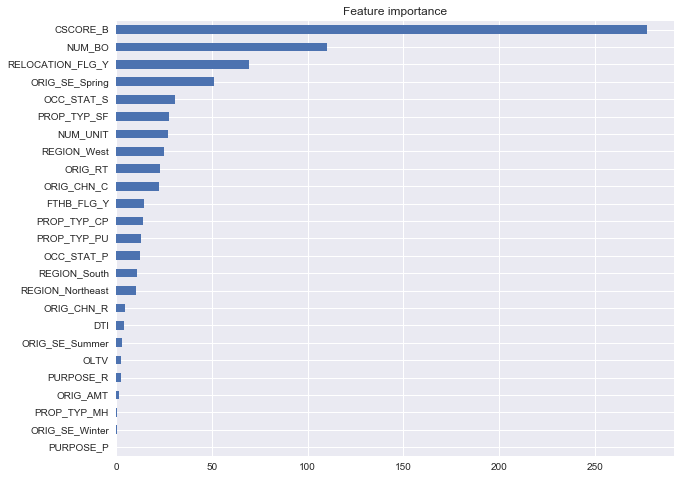

In [1197]:
SelectK = SelectKBest(score_func=chi2, k=10)
pipeline_SelectK = Pipeline([('median_imputer',median_imputer),('scaler', scaler),
                             ('smote', smote), ('clf', SelectK)])
fitted_SelectK=pipeline_SelectK.fit(X,y)
X.columns[fitted_SelectK.named_steps.clf.get_support()].values

SelectK_imp = pd.Series(fitted_SelectK.named_steps.clf.scores_, index=X.columns)
SelectK_imp.sort_values(inplace=True, ascending=True)
SelectK_imp.plot(kind='barh', title='Feature importance')

## Recursive Feature Elimination

In [784]:
from sklearn.feature_selection import RFE
estimator = LogisticRegression(random_state=0)
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X2, y2)
pd.DataFrame({'Predictor':X.columns,'Ranking':selector.ranking_}).sort_values('Ranking')

,Predictor,Ranking
0,ORIG_RT,1
21,RELOCATION_FLG_Y,1
2,OLTV,1
3,NUM_BO,1
5,CSCORE_B,1
6,NUM_UNIT,2
4,DTI,3
15,PROP_TYP_CP,4
10,ORIG_SE_Summer,5
19,OCC_STAT_P,6


In [785]:
estimator = RandomForestClassifier(warm_start=True, oob_score=True,random_state=0,n_estimators=300)
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X2, y2)
pd.DataFrame({'Predictor':X.columns,'Ranking':selector.ranking_}).sort_values('Ranking')

,Predictor,Ranking
0,ORIG_RT,1
2,OLTV,1
3,NUM_BO,1
4,DTI,1
5,CSCORE_B,1
1,ORIG_AMT,2
18,PROP_TYP_SF,3
19,OCC_STAT_P,4
8,ORIG_CHN_R,5
23,REGION_South,6


# Recursive Feature Elimination with Cross Validation

These results appear questionable since every variable was given a 1 ranking.

In [1310]:
from sklearn.feature_selection import RFECV
estimator = RandomForestClassifier(random_state=0)
selector = RFECV(estimator, step=1)
selector = selector.fit(X2, y2)
pd.DataFrame({'Predictor':X.columns,'Ranking':selector.ranking_}).sort_values('Ranking')

,Predictor,Ranking
0,ORIG_RT,1
22,REGION_Northeast,1
21,RELOCATION_FLG_Y,1
20,OCC_STAT_S,1
19,OCC_STAT_P,1
18,PROP_TYP_SF,1
17,PROP_TYP_PU,1
14,FTHB_FLG_Y,1
13,PURPOSE_R,1
23,REGION_South,1


# Feature Relationships with the Outcome

In [1571]:
folds = StratifiedKFold(random_state=0,n_splits=5)
logit=LogisticRegression(random_state=0)
pipeline_logit = Pipeline([('median_imputer',median_imputer),('scaler', scaler),
                        ('smote', smote), ('clf', logit)])
fitted_pipeline=pipeline_logit.fit(X,y)

In [1572]:
feature_coefs=pd.DataFrame(fitted_pipeline.named_steps.clf.coef_,columns=X.columns).unstack(0)
feature_coefs=pd.DataFrame(feature_coefs)
feature_coefs=feature_coefs.reset_index(level=1, drop=True)
feature_coefs.columns=['Coefficient']
feature_coefs.sort_values('Coefficient',ascending=False)
#The below is not true because the numeric predictors are log transformed and min/max scaled
'''
feature_coefs.columns=['Log-Odds']
feature_coefs['Odds Ratio']=feature_coefs['Log-Odds'].map(np.exp)

probs=list()
for j in feature_coefs['Odds Ratio']:
    probs.append(j/(1+j))    
feature_coefs['P(Y=1)']=probs
feature_coefs.sort_values('Log-Odds',ascending=False)
'''

,Coefficient
ORIG_RT,2.843
DTI,2.168
OLTV,1.477
ORIG_SE_Summer,1.013
PROP_TYP_SF,0.803
OCC_STAT_P,0.637
OCC_STAT_S,0.455
PURPOSE_P,0.373
PURPOSE_R,0.371
PROP_TYP_PU,0.319


"\nfeature_coefs.columns=['Log-Odds']\nfeature_coefs['Odds Ratio']=feature_coefs['Log-Odds'].map(np.exp)\n\nprobs=list()\nfor j in feature_coefs['Odds Ratio']:\n    probs.append(j/(1+j))    \nfeature_coefs['P(Y=1)']=probs\nfeature_coefs.sort_values('Log-Odds',ascending=False)\n"

# Building the final model

In [1633]:
method='Gradient Boosting Classifier'
scoring = make_scorer(f1_score)
pipeline = Pipeline([('median_imputer',median_imputer),('scaler', scaler),
                    ('fselect',feature_selection), ('smote', smote), 
                    ('clf', GradientBoostingClassifier(random_state=0, max_features='sqrt'))])
folds = StratifiedKFold(random_state=0)
param = ({"fselect__threshold":[1e-5,1e-4,1e-3],"clf__learning_rate": [.001,.01,.1], "clf__max_depth":[3,4,5]})
random_search = RandomizedSearchCV(pipeline, n_iter=9, param_distributions=param,cv = folds,
                scoring=scoring,random_state=0)
optimized_pipeline = random_search.fit(X,y)    

In [1635]:
np.sum(random_search.best_estimator_.named_steps.fselect.get_support())
random_search.best_params_
X.columns[random_search.best_estimator_.named_steps.fselect.get_support()==False]

24

{'clf__learning_rate': 0.01, 'clf__max_depth': 4, 'fselect__threshold': 0.0001}

Index(['PROP_TYP_CP'], dtype='object')

# Freeform Visualization

# Attempt #1 Principal Component Labels

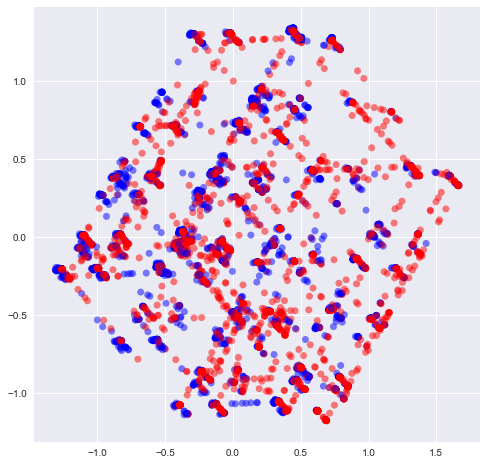

In [1677]:
pca = PCA(n_components=2)
prin_comps = pca.fit_transform(X2)
prin_comps=pd.DataFrame(prin_comps,columns=['PC1', 'PC2'])

m_features =  24
selected_names = ['Defaults', 'Non-Defaults']
gbc=GradientBoostingClassifier(random_state=0, max_features='sqrt',
                              learning_rate=.01,max_depth=4)
gbc_fitted=gbc.fit(X2,y2)
preds=gbc_fitted.predict(X2)

cvec=list()
for j in preds:
    if j == True:
        cvec.append('Red')
    else:
        cvec.append('Blue')
        
plt.figure(figsize=(8,8))
plt.scatter(prin_comps.iloc[:,0], prin_comps.iloc[:,1],c=cvec, edgecolor='', alpha=0.5)